 # Построение осцилляторов и индикаторов на основе акций Microsoft

## Загрузка данных из файла

In [553]:
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tulipy as ti
%matplotlib inline
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
df = joblib.load("../Documents/MSFT.pkl")
df['test'] = df['open']
df.test = df.test.shift(-1) #сдвигаю вниз
y = df['open'].values
z = df['close'].values
high = df['high'].values
low = df['low'].values
#df = df.dropna()           #удаляю первую строку
new_o = df.loc[:,['open']] #фильтр
ewma = pd.Series.ewm

## Cкользящая средняя
![SMA-1.png](img/SMA-1.png)

где SMAt – значение простого скользящего среднего в период времени t;

n – интервал сглаживания;

Pt-i – значение случайной величины на момент (t-i).

In [554]:
#скользящая средняя
def moving_average(new_o, n): 
    MA = pd.Series(new_o['open'].rolling(window=n).mean())
    return MA

## Экспоненциальное скользящее среднее
![EMA-1.png](img/EMA-1.png)

α – весовой коэффициент в интервале от 0 до 1, отражающий скорость старения прошлых данных: чем выше его значение, тем больший удельный вес имеют новые наблюдения случайной величины, и тем меньший старые;

Pt – значение случайной величины в период времени t;

EMAt-1 – значение экспоненциального скользящего среднего в период времени (t-1).

In [555]:
#Экспоненциальная скользящая средняя
def exponential_moving_average(new_o, n):
    EMA = pd.Series(new_o['open'].ewm(span=n, adjust=False).mean())
    return EMA

## Построение графиков средних скользящих

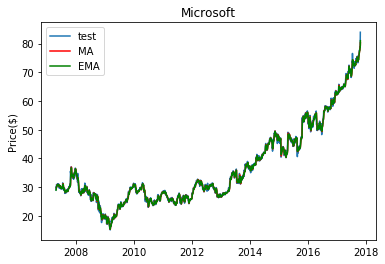

In [556]:
new_o['EMA'] = exponential_moving_average(new_o, 5)
new_o['MA'] = moving_average(new_o, 5)
df['MA'] = new_o['MA']
df['EMA'] = new_o['EMA']
#df = df.loc['2007-04-25':'2007-10-07']  #фильтр для детализации
plt.plot(df.index,df['test'], label='test')
plt.plot(df.index,df['MA'],label='MA', color = 'red')
plt.plot(df.index,df['EMA'],label='EMA', color = 'green')
plt.legend()
plt.title('Microsoft')
plt.ylabel('Price($)')
plt.show()

## RSI
![RSI-formula.png](img/RSI-formula.png)

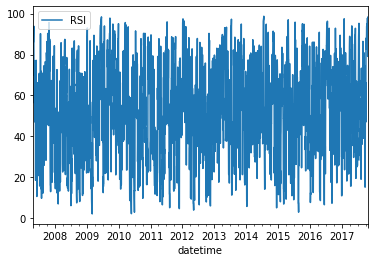

In [557]:
def RSI(series, n):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[n-1]] = np.mean( u[:n] ) 
    u = u.drop(u.index[:(n-1)])
    d[d.index[n-1]] = np.mean( d[:n] ) 
    d = d.drop(d.index[:(n-1)])
    rs = pd.Series.ewm(u, com=n-1, adjust=False).mean()  / pd.Series.ewm(d, com=n-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)
df['RSI'] = RSI(df.close, 5)
df.plot(y=['RSI'])

## Стохастический осциллятор
![stochastic-1.png](img/stochastic-1.png)

где N – количество периодов;

Ct – цена закрытия в период времени t;

HN – максимальное значение цены за последние N периодов;

LN – минимальное значение цены за последние N периодов.

Формула расчета %D в период времени t представляет собой простое скользящее среднее %K с интервалом сглаживания m.

![stochastic-2.png](img/stochastic-2.png)

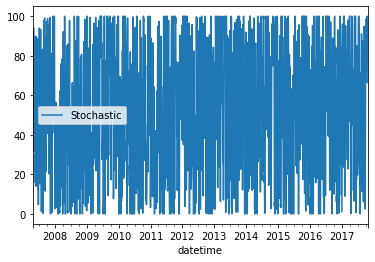

In [558]:
#Стохастик индикатор

def stochastic_oscillator(close, low, high, n, k):
    SOk = ((close-pd.Series(low.rolling(window = n).min())) / (pd.Series(high.rolling(window = n).max()) - pd.Series(low.rolling(window = n).min()))) * 100
    SOk = pd.Series(SOk.rolling(window = k).mean())
    SOd = pd.Series(SOk.rolling(window = k).mean())
    return SOd
df['Stochastic'] = stochastic_oscillator(df['close'],df['low'],df['high'], 5, 3)
df.plot(y=['Stochastic'])

## Библиотека Tulip


In [559]:
#Tulip Indicators
stoch_k, stoch_d = ti.stoch(high, low, z, 5, 3, 3)
sma = ti.sma(y, 5)
rsi = ti.rsi(z, 5)
ema = ti.ema(y,5)
print('MA: ', sma)
print('EMA: ',ema)
print('RSI: ',rsi)
print('Stochastic: ',stoch_d)

MA:  [29.708 29.898 30.158 ... 78.778 79.278 80.314]
EMA:  [28.99       29.02666667 29.40111111 ... 78.67755184 79.5383679
 81.0055786 ]
RSI:  [86.25954198 90.45092838 91.86670432 ... 79.05515358 96.30482485
 98.23583513]
Stochastic:  [93.87931034 92.42898238 82.69909537 ... 88.88888889 77.6048422
 66.3207955 ]


## Сравнение RSI

In [560]:
df['RSI'].dropna().head(10).values

array([86.25954198, 90.45092838, 91.86670432, 93.82768967, 69.85171668,
       69.85171668, 69.85171668, 74.50661468, 75.75445299, 76.81483466])

In [561]:
rsi[:10]

array([86.25954198, 90.45092838, 91.86670432, 93.82768967, 69.85171668,
       69.85171668, 69.85171668, 74.50661468, 75.75445299, 76.81483466])

## Сравнение Стохастика

In [562]:
df['Stochastic'].dropna().head(10).values

array([93.87931034, 92.42898238, 82.69909537, 59.63587502, 37.90936019,
       31.61169526, 47.04832985, 62.00930835, 70.08919524, 68.03381643])

In [563]:
stoch_d[:10]

array([93.87931034, 92.42898238, 82.69909537, 59.63587502, 37.90936019,
       31.61169526, 47.04832985, 62.00930835, 70.08919524, 68.03381643])

## Сравнение графиков

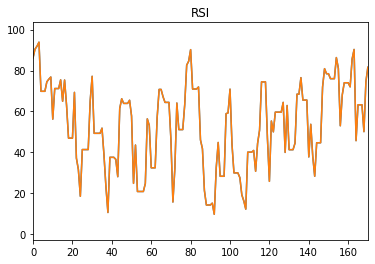

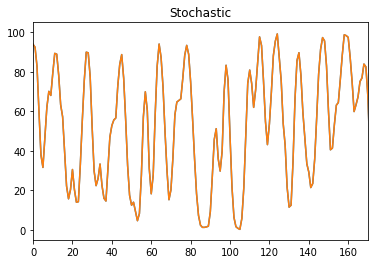

In [564]:
grafic = df['RSI'].dropna().values
plt.plot(rsi)
plt.plot(grafic)
plt.xlim(0, 170)
plt.title('RSI')
plt.show()
grafic1 = df['Stochastic'].dropna().values
plt.plot(stoch_d)
plt.plot(grafic1)
plt.xlim(0, 170)
plt.title('Stochastic')
plt.show()

## Линейная регрессия(draft)

In [565]:
import sklearn
from sklearn.linear_model import LinearRegression
a = df['MA'].values.reshape((-1,1))
b = df['test'].values
a=a[4:100]
b=b[4:100]
c=df['open'].values
c=c[4:100]
model = LinearRegression().fit(a,b)
print(model.score(a,b))
print(model.intercept_)
print(model.coef_)
b_pred = model.predict(a)
print(b[:5])
print('Predicted: ', b_pred[:5])
mse = sklearn.metrics.mean_squared_error(b, b_pred)
r2 = sklearn.metrics.r2_score(b, b_pred)
print('MSE: ', mse)
print('R2: ', r2)

0.5265676606261873
4.458635913496725
[0.85209963]
[29.94 30.4  30.58 30.97 30.56]
Predicted:  [29.77281177 29.9347107  30.1562566  30.22953717 30.36928151]
MSE:  0.1603575730850062
R2:  0.5265676606261873


In [566]:
#объединение dataframe
#b_pred = pd.DataFrame(data = b_pred, index = df.index.values, columns = ['Pred'])
#b_pred.head()

## Линейная регрессия с окнами 7, 14, 30
### Средняя скользящая

In [567]:
from sklearn.model_selection import train_test_split
periods = 7
#periods = 14
#periods = 30
X = np.array(df[['open','MA']])
for i in range(1,7):
    df[i] = df['MA'].shift(i)
    X = np.append(X,np.array(df[[i]]),axis=1)
#X = X[~np.isnan(X).any(axis=1)]
X = X[10:-1]
Y = np.array(df['test'])
Y = Y[10:-1]
X1 = np.array(df[['open','MA']])
for i in range(1,14):
    df[i] = df['MA'].shift(i)
    X1 = np.append(X1,np.array(df[[i]]),axis=1)
X1 = X1[17:-1]
Y1 = np.array(df['test'])
Y1 = Y1[17:-1]
X2 = np.array(df[['open','MA']])
for i in range(1,30):
    df[i] = df['MA'].shift(i)
    X2 = np.append(X2,np.array(df[[i]]),axis=1)
X2 = X2[33:-1]
Y2 = np.array(df['test'])
Y2 = Y2[33:-1]
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.2, random_state = 42)
xTrain1, xTest1, yTrain1, yTest1 = train_test_split(X1, Y1, test_size = 0.2, random_state = 42)
xTrain2, xTest2, yTrain2, yTest2 = train_test_split(X2, Y2, test_size = 0.2, random_state = 42)
lr = LinearRegression().fit(xTrain, yTrain)
Y_pred = lr.predict(xTest)
lr1 = LinearRegression().fit(xTrain1,yTrain1)
Y1_pred = lr1.predict(xTest1)
lr2 = LinearRegression().fit(xTrain2,yTrain2)
Y2_pred = lr2.predict(xTest2)
print('R^2, window=7: ', lr.score(xTest, yTest)) # R^2
print('Predicted first 5 values:', Y_pred[:5], sep='\n')
df1 = pd.DataFrame({'Actual': yTest, 'Predicted': Y_pred})
print('R^2, window=14: ', lr1.score(xTest1,yTest1))
print('Predicted first 5 values:', Y1_pred[:5], sep='\n')
df2 = pd.DataFrame({'Actual': yTest1, 'Predicted': Y1_pred})
print('R^2, window=30: ', lr2.score(xTest2,yTest2))
print('Predicted first 5 values:', Y2_pred[:5], sep='\n')
df3 = pd.DataFrame({'Actual': yTest2, 'Predicted': Y2_pred})

R^2, window=7:  0.9988741434521966
Predicted first 5 values:
[48.22111242 69.06059351 31.02302426 43.59767391 26.01098823]
R^2, window=14:  0.998818468032299
Predicted first 5 values:
[47.81828889 26.17778442 33.72918561 61.24222144 44.36739255]
R^2, window=30:  0.9988932690503377
Predicted first 5 values:
[26.61544804 21.95143023 24.64408996 28.0919808  25.60073865]


### Линейная регрессия с RSI

In [568]:
dff=df.loc[:,['test','MA','RSI']]
dff['test'] = dff['RSI'].shift(1)
X3 = np.array(dff['RSI'])
#for i in range(1,7):
    #dff[i] = dff['RSI'].shift(i)
    #X3 = np.concatenate(X3,np.array(dff[[i]]))
X3 = X3[11:]
Y3 = np.array(dff['test'])
Y3 = Y3[11:]

#xTrain3, xTest3, yTrain3, yTest3 = train_test_split(X3, Y3, test_size = 0.2, random_state = 42)
#lr3 = LinearRegression().fit(xTrain3, yTrain3)
#Y3_pred = lr3.predict(xTest3)

#print('R^2, window=7: ', lr.score(xTest3, yTest3)) # R^2
#print('Predicted first 5 values:', Y3_pred[:5], sep='\n')
#df4 = pd.DataFrame({'Actual': yTest3, 'Predicted': Y3_pred})

In [569]:
dff

,test,MA,RSI
datetime,,,
2007-04-25,NaN,NaN,NaN
2007-04-26,NaN,NaN,NaN
2007-04-27,NaN,NaN,NaN
2007-04-28,NaN,NaN,NaN
2007-04-29,NaN,29.708,NaN
2007-04-30,NaN,29.898,86.259542
2007-05-01,86.259542,30.158,90.450928
2007-05-02,90.450928,30.244,91.866704
2007-05-03,91.866704,30.408,93.827690


In [570]:
X3

array([69.85171668, 74.50661468, 75.75445299, ..., 79.05515358,
       96.30482485, 98.23583513])

In [571]:
yTrain

array([55.26, 57.99, 23.67, ..., 24.85, 61.97, 51.72])

### Сравнение по средней с окном в 7 дней

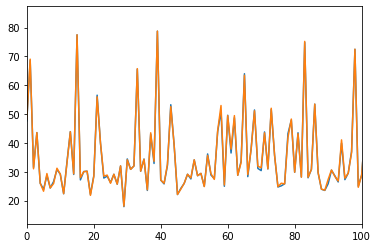

,Actual,Predicted
0,47.6500,48.221112
1,68.6500,69.060594
2,31.4800,31.023024
3,43.5500,43.597674
4,26.0200,26.010988
5,23.9000,23.245031
6,28.7300,29.370814
7,24.3700,24.367727
8,26.6000,25.907843
9,30.8100,31.213877


In [572]:
plt.plot(yTest)
plt.plot(Y_pred)
plt.xlim(0, 100)
plt.show()
df1

In [573]:
df2

,Actual,Predicted
0,47.750,47.818289
1,26.190,26.177784
2,33.260,33.729186
3,61.090,61.242221
4,44.120,44.367393
5,25.800,25.851139
6,53.865,52.636074
7,52.350,53.114153
8,40.300,40.204009
9,48.210,48.425350


In [574]:
df3

,Actual,Predicted
0,26.650,26.615448
1,21.730,21.951430
2,25.300,24.644090
3,28.100,28.091981
4,25.680,25.600739
5,40.250,40.502029
6,33.280,33.311521
7,37.500,37.324453
8,24.460,24.704381
9,65.770,65.402490


In [575]:
df['MA']

datetime
2007-04-25       NaN
2007-04-26       NaN
2007-04-27       NaN
2007-04-28       NaN
2007-04-29    29.708
2007-04-30    29.898
2007-05-01    30.158
2007-05-02    30.244
2007-05-03    30.408
2007-05-04    30.490
2007-05-05    30.614
2007-05-06    30.646
2007-05-07    30.672
2007-05-08    30.628
2007-05-09    30.672
2007-05-10    30.676
2007-05-11    30.742
2007-05-12    30.778
2007-05-13    30.806
2007-05-14    30.848
2007-05-15    30.916
2007-05-16    30.952
2007-05-17    30.970
2007-05-18    30.958
2007-05-19    30.926
2007-05-20    30.908
2007-05-21    30.906
2007-05-22    30.848
2007-05-23    30.798
2007-05-24    30.670
               ...  
2017-09-28    73.750
2017-09-29    73.792
2017-09-30    74.038
2017-10-01    74.282
2017-10-02    74.442
2017-10-03    74.504
2017-10-04    74.526
2017-10-05    74.814
2017-10-06    75.096
2017-10-07    75.364
2017-10-08    75.696
2017-10-09    76.032
2017-10-10    76.104
2017-10-11    76.204
2017-10-12    76.426
2017-10-13    76.734
2017